In [1]:
import numpy as np
import os
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import pandas as pd
import sys
#from scipy import ndimage as ndi
%matplotlib inline
from utils import get_biomass

In [2]:
veg_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/2019/pp_veg_structure.csv')
den_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/GlobalWoodDensityDatabase.csv')
# veg_df = veg_df.drop(['Unnamed: 0'], axis=1)

In [3]:
processed_veg_df = veg_df[(~pd.isna(veg_df.basalStemDiameter) |
           ~pd.isna(veg_df.stemDiameter))]

In [4]:
result = []
for row in processed_veg_df.itertuples():
    val = np.nan
    if row.scientificName != 'Unknown plant':
        val = get_biomass(row.scientificName, row.stemDiameter, row.basalStemDiameter)
    result.append(val)
# result

In [5]:
processed_veg_df['biomass'] = result

/tmp/ipykernel_738398/3561468032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_veg_df['biomass'] = result


In [6]:
processed_veg_df[['Unnamed: 0', 'individualID', 'biomass']]

,Unnamed: 0,individualID,biomass
0,1691,NEON.PLA.D17.SOAP.03619,1.203477
1,2110,NEON.PLA.D17.SOAP.04010,238.663376
2,2111,NEON.PLA.D17.SOAP.04101,325.931010
3,2112,NEON.PLA.D17.SOAP.04102,21.516141
4,2113,NEON.PLA.D17.SOAP.04103,775.195817
...,...,...,...
874,3003,NEON.PLA.D17.SOAP.05898,NaN
875,3004,NEON.PLA.D17.SOAP.05898,NaN
876,3005,NEON.PLA.D17.SOAP.05899,NaN
877,3006,NEON.PLA.D17.SOAP.05899,NaN


In [7]:
val = processed_veg_df[['Unnamed: 0', 'biomass']]
p_veg_df = veg_df.merge(val, how='left', on='Unnamed: 0')
p_veg_df.shape

(879, 41)

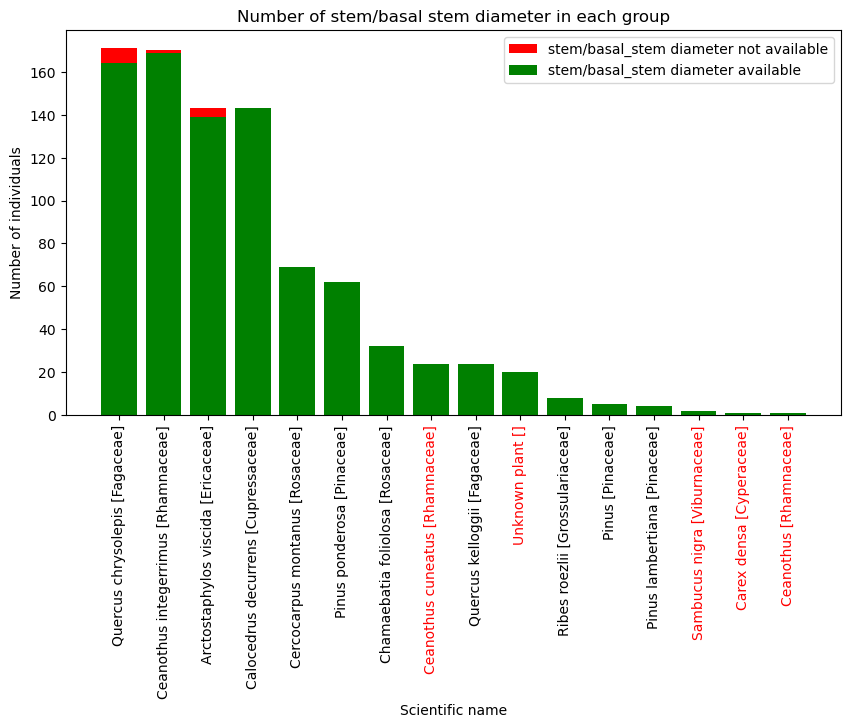

In [29]:
from pygbif import species

values = {}
groups = p_veg_df.groupby('scientificName')
for name, group in groups:
    nan_values = pd.isna(group.stemDiameter) & pd.isna(group.basalStemDiameter)
    is_biomass = (~pd.isna(group.biomass)).any()
    values[name] = [np.sum(~nan_values), np.sum(nan_values), is_biomass]

values = sorted(values.items(), key=lambda x: -(x[1][0] + x[1][1]))
X = [v[0] for v in values]
avail = np.array([i[1][0] for i in values])
nan = np.array([i[1][1] for i in values])
color = [i[0] for i in values if i[1][2]]

fig, axs = plt.subplots(figsize=(10, 5))
X_axis = np.arange(len(X))
plt.bar(X_axis, avail+nan, label='stem/basal_stem diameter not available', color='red')
plt.bar(X_axis, avail, label='stem/basal_stem diameter available', color='green')
plt.xticks(X_axis, X)
[label.set_color('red') for label in axs.xaxis.get_ticklabels() if label.get_text() not in color]
name_family = []
for name in X:
    genus, s = name.split()[:2]
    if s == 'sp.':
        s = ''
    if s != '':
        n = ' '.join([genus, s])
    else:
        n = genus
    try:
        family = species.name_backbone(n)['family']
    except:
        family = None
    name_family.append((n, family))
plt.xticks(X_axis, [f"{i[0]} [{i[1] if i[1] else ''}]" for i in name_family])
plt.xticks(rotation = 90)
plt.xlabel("Scientific name")
plt.ylabel("Number of individuals")
plt.title("Number of stem/basal stem diameter in each group")
plt.legend()
plt.show()


In [28]:
name_family

[('Quercus chrysolepis', None),
 ('Ceanothus integerrimus', None),
 ('Arctostaphylos viscida', None),
 ('Calocedrus decurrens', None),
 ('Cercocarpus montanus', None),
 ('Pinus ponderosa', None),
 ('Chamaebatia foliolosa', None),
 ('Ceanothus cuneatus', None),
 ('Quercus kelloggii', None),
 ('Unknown plant', None),
 ('Ribes roezlii', None),
 ('Pinus', None),
 ('Pinus lambertiana', None),
 ('Sambucus nigra', None),
 ('Carex densa', None),
 ('Ceanothus', None)]

In [12]:
color

array(['Quercus chrysolepis Liebm.',
       'Ceanothus integerrimus Hook. & Arn.',
       'Arctostaphylos viscida Parry ssp. mariposa (Dudley) P.V. Wells',
       'Calocedrus decurrens (Torr.) Florin',
       'Cercocarpus montanus Raf. var. glaber (S. Watson) F.L. Martin',
       'Pinus ponderosa Lawson & C. Lawson',
       'Chamaebatia foliolosa Benth.', 'Quercus kelloggii Newberry',
       'Ribes roezlii Regel', 'Pinus sp.', 'Pinus lambertiana Douglas'],
      dtype='<U62')

In [14]:
axs.xaxis.get_ticklabels()

[Text(0, 0, 'Quercus chrysolepis'),
 Text(1, 0, 'Ceanothus integerrimus'),
 Text(2, 0, 'Arctostaphylos viscida'),
 Text(3, 0, 'Calocedrus decurrens'),
 Text(4, 0, 'Cercocarpus montanus'),
 Text(5, 0, 'Pinus ponderosa'),
 Text(6, 0, 'Chamaebatia foliolosa'),
 Text(7, 0, 'Ceanothus cuneatus'),
 Text(8, 0, 'Quercus kelloggii'),
 Text(9, 0, 'Unknown plant'),
 Text(10, 0, 'Ribes roezlii'),
 Text(11, 0, 'Pinus sp.'),
 Text(12, 0, 'Pinus lambertiana'),
 Text(13, 0, 'Sambucus nigra'),
 Text(14, 0, 'Carex densa'),
 Text(15, 0, 'Ceanothus sp.')]

In [34]:
veg_df.keys()

Index(['individualID', 'domainID', 'siteID', 'plotID', 'subplotID', 'pointID',
       'stemDistance', 'stemAzimuth', 'scientificName', 'taxonRank',
       'adjNorthing', 'adjEasting', 'adjCoordinateUncertainty',
       'adjDecimalLatitude', 'adjDecimalLongitude', 'adjElevation',
       'adjElevationUncertainty', 'growthForm', 'plantStatus', 'stemDiameter',
       'measurementHeight', 'height', 'baseCrownHeight', 'breakHeight',
       'breakDiameter', 'maxCrownDiameter', 'ninetyCrownDiameter',
       'canopyPosition', 'shape', 'basalStemDiameter',
       'basalStemDiameterMsrmntHeight', 'maxBaseCrownDiameter',
       'ninetyBaseCrownDiameter', 'initialBandStemDiameter',
       'initialDendrometerGap', 'dendrometerHeight', 'dendrometerGap',
       'dendrometerCondition', 'bandStemDiameter'],
      dtype='object')

"/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_296000_4100000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_297000_4100000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_297000_4101000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_298000_4100000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_298000_4101000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_299000_4100000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_299000_4101000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_300000_4100000_classified_point_cloud_colorized.laz" "/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_300000_4101000_classified_point_cloud_colorized.laz" 

In [14]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
polygons = gpd.read_file('/home/toanngo/Documents/GitHub/prisma/All_NEON_TOS_Plots_V9_0/All_NEON_TOS_Plots_V9/All_NEON_TOS_Plot_Polygons_V9.shp')
polygons_soap = polygons[polygons.siteID == 'SOAP']
polygons_soap_utm = polygons_soap.to_crs('epsg:32611')

In [16]:
veg_df.plotID.unique()

array(['SOAP_009', 'SOAP_021', 'SOAP_002', 'SOAP_010', 'SOAP_013',
       'SOAP_006', 'SOAP_012', 'SOAP_004', 'SOAP_020', 'SOAP_007',
       'SOAP_017', 'SOAP_015', 'SOAP_016', 'SOAP_003', 'SOAP_018',
       'SOAP_008', 'SOAP_019'], dtype=object)

In [17]:
for plotID in veg_df.plotID.unique():
    polygons_soap_utm_plot = polygons_soap_utm[polygons_soap_utm.plotID == plotID]
    polygons_soap_utm_plot = polygons_soap_utm_plot[polygons_soap_utm_plot.pointID == '41']
    polygons_soap_utm_plot.to_file(f'/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/shapefile_plot/plot_polygons_{plotID}.shp')

In [42]:
polygons_soap_utm.pointID == 41

1811    False
1812    False
1813    False
1814    False
1815    False
        ...  
1879    False
1880    False
1881    False
1882    False
1883    False
Name: pointID, Length: 73, dtype: bool

In [18]:
polygons_soap_utm['area'] = polygons_soap_utm.area
polygons_soap_utm_avail = polygons_soap_utm[polygons_soap_utm.plotID.isin(list(veg_df.plotID.unique()))]
polygons_soap_utm_avail = polygons_soap_utm_avail[polygons_soap_utm_avail.pointID == '41']
polygons_soap_utm_avail.explore("area", legend=False)

In [10]:
processed_veg_df.plantStatus.unique()

array(['Standing dead', 'Live', 'Live,  other damage',
       'Live, broken bole', 'Dead, broken bole',
       'Live, physically damaged', 'Live, disease damaged'], dtype=object)

In [31]:
polygons = polygons_soap_utm_avail
veg_df = processed_veg_df

In [32]:
polygons['area'] = polygons.area
polygons_area = polygons[['plotID', 'geometry', 'area']]
veg_area_df = pd.merge(veg_df, polygons_area, on=['plotID'])
veg_area_df = veg_area_df[~pd.isna(veg_area_df.biomass)]
veg_area_df['individualStemNumberDensity'] = 1/veg_area_df.area
veg_area_df['individualBasalArea'] = np.pi/4*veg_area_df.stemDiameter**2


In [22]:
veg_area_df.to_csv('pp_veg_structure_IND_IBA_IAGB.csv', index=False)

In [25]:
plots = []
ND = []
BA = []
ABCD = []

for plot_id, group in veg_area_df.groupby('plotID'):
    plots.append(plot_id)
    ND.append(group.individualStemNumberDensity.sum())
    BA.append((group.individualStemNumberDensity * group.individualBasalArea).sum())
    ABCD.append((group.individualStemNumberDensity * group.biomass).sum())

In [24]:
(veg_area_df.individualStemNumberDensity * veg_area_df.individualBasalArea).sum()

198.66257771019963

In [26]:
plot_level_df = pd.DataFrame.from_dict({'plotID': plots,
                        'stemNumberDensity': ND,
                        'basalArea': BA,
                        'biomass': ABCD})


In [28]:
plot_level_df.to_csv('plot_level_pp_veg_structure_IND_IBA_IAGB.csv', index=False)

In [29]:
veg_area_df_live = veg_area_df[~veg_area_df.plantStatus.isin(['Standing dead', 'Dead, broken bole'])]

In [30]:
polygons = polygons_soap_utm_avail
veg_df = veg_area_df_live
polygons['area'] = polygons.area
polygons_area = polygons[['plotID', 'geometry', 'area']]
veg_area_df = pd.merge(veg_df, polygons_area, on=['plotID'])
veg_area_df = veg_area_df[~pd.isna(veg_area_df.biomass)]
veg_area_df['individualStemNumberDensity'] = 1/veg_area_df.area
veg_area_df['individualBasalArea'] = np.pi/4*veg_area_df.stemDiameter**2


AttributeError: 'DataFrame' object has no attribute 'area'

In [35]:
veg_area_df_live.to_csv('pp_veg_structure_IND_IBA_IAGB_live.csv', index=False)

In [34]:
plots = []
ND = []
BA = []
ABCD = []

for plot_id, group in veg_area_df_live.groupby('plotID'):
    plots.append(plot_id)
    ND.append(group.individualStemNumberDensity.sum())
    BA.append((group.individualStemNumberDensity * group.individualBasalArea).sum())
    ABCD.append((group.individualStemNumberDensity * group.biomass).sum())

plot_level_df_live = pd.DataFrame.from_dict({'plotID': plots,
                        'stemNumberDensity': ND,
                        'basalArea': BA,
                        'biomass': ABCD})
plot_level_df_live.to_csv('plot_level_pp_veg_structure_IND_IBA_IAGB_live.csv', index=False)